C:\Users\Вася\AppData\Local\Temp\ipykernel_32008\832040553.py:52: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(


Найкращі параметри для Дерево рішень: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Найкращі параметри для Випадковий ліс: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Найкращі параметри для SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Дерево рішень (Валідація): MSE = 0.0020, R² = 0.9970
Випадковий ліс (Валідація): MSE = 0.0002, R² = 0.9997
SVM (Валідація): MSE = 0.0274, R² = 0.9598
Дерево рішень (Тест): MSE = 0.6319, R² = 0.7590
Випадковий ліс (Тест): MSE = 0.2948, R² = 0.8876
SVM (Тест): MSE = 0.5205, R² = 0.8015


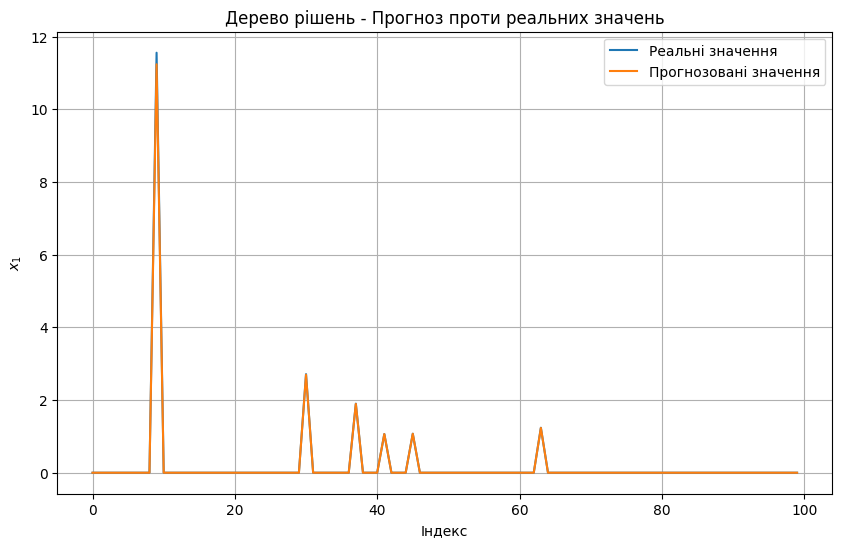

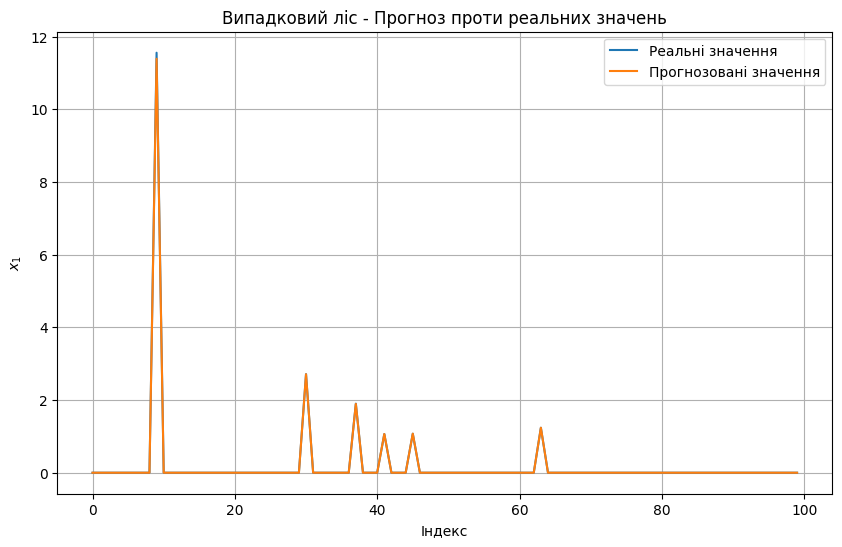

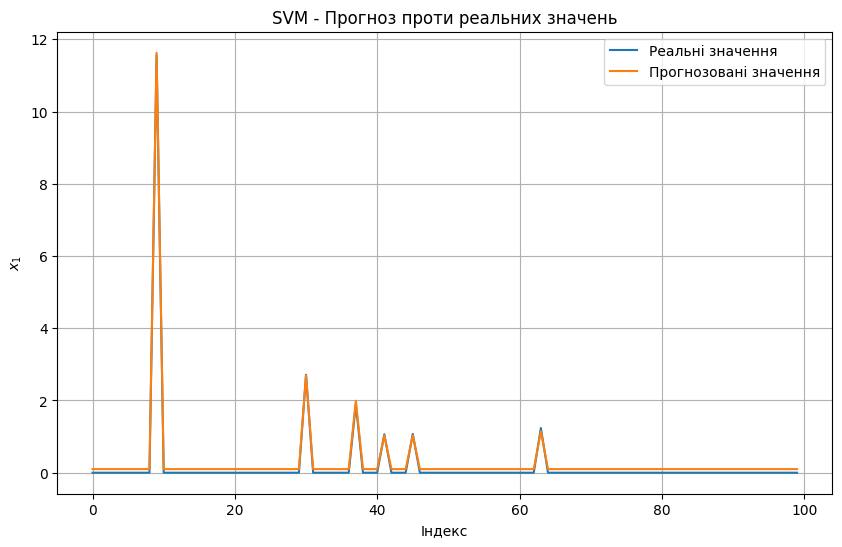

In [2]:
import numpy as np
from scipy.integrate import odeint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


def variant17_system(
    state, t,
    a1, a2,
    b1, b2
):
    x1, x2 = state
    dx1dt = (
        a1 * x1**2 * np.cos(x2)
        - b1 * x1 * x2
    )
    dx2dt = (
        -a2 * x2
        + b2 * np.sin(x1**2)
    )
    return [
        dx1dt,
        dx2dt
    ]

a1, a2 = 0.5, 0.7
b1, b2 = 0.2, 0.3


initial_state = [
    1.0,
    0.5
]
time = np.linspace(
    0, 50, 10000
)

solution = odeint(
    variant17_system,
    initial_state,
    time,
    args=(
        a1, a2,
        b1, b2
    )
)

X = solution[:-1]
y = solution[1:, 0] 

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.2,
    random_state=42
)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(
    X_train
)
X_val_scaled = scaler.transform(
    X_val
)
X_test_scaled = scaler.transform(
    X_test
)


models = {
    'Лінійна регресія': LinearRegression(),
    'Дерево рішень': DecisionTreeRegressor(
        random_state=42
    ),
    'Випадковий ліс': RandomForestRegressor(
        random_state=42
    ),
    'SVM': SVR()
}

for name, model in models.items():
    model.fit(
        X_train_scaled,
        y_train
    )

param_grids = {
    'Дерево рішень': {
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 5]
    },
    'Випадковий ліс': {
        'n_estimators': [50, 100],
        'max_depth': [5, 10],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 5]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
}

best_models = {}

for name, param_grid in param_grids.items():
    grid_search = GridSearchCV(
        models[name],
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error'
    )
    grid_search.fit(
        X_train_scaled,
        y_train
    )
    best_models[name] = grid_search.best_estimator_
    print(
        f"Найкращі параметри для {name}: {grid_search.best_params_}"
    )

for name, model in best_models.items():
    y_pred = model.predict(
        X_val_scaled
    )
    mse = mean_squared_error(
        y_val,
        y_pred
    )
    r2 = r2_score(
        y_val,
        y_pred
    )
    print(
        f"{name} (Валідація): MSE = {mse:.4f}, R² = {r2:.4f}"
    )

for name, model in best_models.items():
    y_pred_test = model.predict(
        X_test_scaled
    )
    mse_test = mean_squared_error(
        y_test,
        y_pred_test
    )
    r2_test = r2_score(
        y_test,
        y_pred_test
    )
    print(
        f"{name} (Тест): MSE = {mse_test:.4f}, R² = {r2_test:.4f}"
    )

for name, model in best_models.items():
    y_pred = model.predict(
        X_test_scaled
    )
    plt.figure(
        figsize=(10, 6)
    )
    plt.plot(
        y_test[:100],
        label="Реальні значення"
    )
    plt.plot(
        y_pred[:100],
        label="Прогнозовані значення"
    )
    plt.title(
        f"{name} - Прогноз проти реальних значень"
    )
    plt.xlabel(
        'Індекс'
    )
    plt.ylabel(
        '$x_1$'
    )
    plt.legend()
    plt.grid()
    plt.show()
